## Question 3 - Dogs vs Cats binary classification

Dogs vs. Cats is an InclassKaggle challenge for image classication. Using what you have learned
from the class and from previous problems, make an attempt at training the best CNN classifier
for this task. Use the link here5 to download the data and access the competition. Make sure to
read the description and the rules thoroughly.

$\bullet$ The data is already preprocessed and ready to use, but you are free to add more layers of
preprocessing if you wish. You may for example do your own cropping. Any extra preprocess-
ing step should be mentioned in your report. You are not allowed to use any external data
sources, but you can use usual data augmentation techniques. Please make sure to mention
them. You are responsible for splitting the train set to an actual train and validation sets
yourself.

$\bullet$ In addition to Kaggle submissions, we require that you submit your code through Gradescope,
along with your report. We will run your code and make sure we can recreate your submission.

$\bullet$ You cannot use things that we have not covered in the class, directly from the deep learn-
ing library you are using, such as BatchNorm/WeightNorm/LayerNorm layers, regularization
techniques (including dropout), and optimizers such as ADAM, "unless you implement them
yourself".

$\bullet$ This problem is meant to give you a chance to play with the methods seen in class and apply
them to a real classification task. Show your efforts by recording what you have tried on the
report (even things that did not lead to high scores).

$\bullet$ Your mark will be a combination of the accuracy score you obtained on the private leaderboard
(more details on Kaggle) and the quality of your report. Your report should include the
answers to the following questions:

**Important: The Kaggle submission deadline is 1 day before the assignment deadline.**

1. Describe the architecture (number of layers, flter sizes, pooling, etc.), and report the number
of parameters. You can take inspiration from some modern deep neural network architectures
such as the VGG networks to improve the performance.


2. Plot the training error and validation error curves, along with the training and validation
losses. Comment on them. What techniques (you did not implement) could be useful to
improve the validation performance. How does your validation performance compare to the
test set performance (that you can only get in Kaggle).


3. Compare different hyperparameter settings and report the final results of performance on
your validation set. Aside from quantitative results, also include some visual analysis such as
visualizing the feature maps or kernels, or showing examples where the images are (a) clearly
misclassified and (b) where the classifier predicts around 50% on both classes. Explain your
observation and/or suggest any improvements you think may help.

## Google colab supporting if necessary

In [2]:
import torch
import os

#if use Google colab, enable this flag
USE_GOOGLE_COLAB = False

if USE_GOOGLE_COLAB:
    from google.colab import drive
    !pip3 install torch torchvision
    !pip3 install pillow==4.1.1
    %reload_ext autoreload
    %autoreload
    
    drive.mount("/content/drive")
    
    # Change to be your own directory!!!
    os.chdir("drive/My Drive/Colab_20190203")
    !ls
    
    # use GPU as priority if available
    if torch.cuda.is_available():
        device = torch.device('cuda')
        use_cuda = True
    else:
        device = torch.device('cpu')
        use_cuda = False
    
    print(device)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
 Kaggle_0205.ipynb
 Kaggle_0206.ipynb
 Kaggle_0208.ipynb
'ksz3_psz2_channel_0_data_augumentation2019-02-10 18:12:12.854252.h5'
'ksz3_psz2_channel_0_data_augumentation2019-02-14 20:29:51.342098.h5'
'ksz3_psz2_channel_0_no_data_augumentation2019-02-10 15:10:37.977946.h5'
'ksz3_psz2_channel_0_no_data_augumentation2019-02-14 00:09:58.576168.h5'
'ksz3_psz2_channel_0_no_data_augumentation2019-02-14 00:59:29.104721.h5'
'ksz3_psz2_channel_0_no_data_augumentation2019-0

## Split training data in order to fit Keras data generator

### Prepare directories

In [0]:
import os

# Path to directory where the original trainset which is unzipped correctly
# The correct directory structure should be 
#                       workspace/trainset/Cat/"images of cats are here"
#                       workspace/trainset/Dog/"images of dogs are here"
original_dataset_dir = "trainset"

# In order to use ImageDataGenerator of Keras, we need to copy all train datas into 
# train and validation directories
base_dir = "trainset_after_copy"

if not os.path.exists(base_dir):
    os.mkdir(base_dir)

# directory of training data
train_dir = os.path.join(base_dir, "train") 
if not os.path.exists(train_dir):
    os.mkdir(train_dir)
    
train_dogs_dir = os.path.join(train_dir, "dogs")
if not os.path.exists(train_dogs_dir):
    os.mkdir(train_dogs_dir)
    
train_cats_dir = os.path.join(train_dir, "cats")
if not os.path.exists(train_cats_dir):
    os.mkdir(train_cats_dir)
    
# directory of validation data
validation_dir = os.path.join(base_dir, "validation")
if not os.path.exists(validation_dir):
    os.mkdir(validation_dir)
    
validation_dogs_dir = os.path.join(validation_dir, "dogs")
if not os.path.exists(validation_dogs_dir):
    os.mkdir(validation_dogs_dir)

validation_cats_dir = os.path.join(validation_dir, "cats")
if not os.path.exists(validation_cats_dir):
    os.mkdir(validation_cats_dir)

### Copy data if necessary

In [5]:
import shutil
import sys

# When run following code on Google colab at the first time,
# there will be an error "OSError: [Errno 5] Input/output error"
# This should not be an problem of this code
# just need run this code block again!!

N_TRAINING_DATA = 8000
N_TOTAL_DATA = 9999

# for displaying progress during copying files
def show_progress(job_title, progress):
    length = 20
    block = int(round(length*progress))
    msg = "\r{0}: [{1}] {2}%".format(job_title, "*"*block + "-"*(length-block), round(progress*100, 2))
    if progress >= 1.0: 
        msg += " DONE\n"
    sys.stdout.write(msg)
    sys.stdout.flush()

#Copy first N_TRAINING_DATA cat images to train_cats_dir
fnames = ["{}.Cat.jpg".format(i) for i in range (1, N_TRAINING_DATA+1)]
n_files = len(fnames)
for idx, fname in enumerate(fnames):
    src = os.path.join(original_dataset_dir + "/Cat", fname)
    dst = os.path.join(train_cats_dir, fname)
    if not os.path.isfile(dst):
        shutil.copyfile(src, dst)
    show_progress("Copying training cats images", (idx+1)/n_files)
    
#Copy left cat images to validation_cats_dir
fnames = ["{}.Cat.jpg".format(i) for i in range (N_TRAINING_DATA+1, N_TOTAL_DATA+1)]
n_files = len(fnames)
for idx, fname in enumerate(fnames):
    src = os.path.join(original_dataset_dir + "/Cat", fname)
    dst = os.path.join(validation_cats_dir, fname)
    if not os.path.isfile(dst):
        shutil.copyfile(src, dst)
    show_progress("Copying validation cats images", (idx+1)/n_files)
    
#Copy first N_TRAINING_DATA dog images to train_dogs_dir
fnames = ["{}.Dog.jpg".format(i) for i in range (1, N_TRAINING_DATA+1)]
n_files = len(fnames)
for idx, fname in enumerate(fnames):
    src = os.path.join(original_dataset_dir + "/Dog", fname)
    dst = os.path.join(train_dogs_dir, fname)
    if not os.path.isfile(dst):
        shutil.copyfile(src, dst)
    show_progress("Copying training dogs images", (idx+1)/n_files)
    
#Copy left dog images to validation_dogs_dir  
fnames = ["{}.Dog.jpg".format(i) for i in range (N_TRAINING_DATA+1, N_TOTAL_DATA+1)]
n_files = len(fnames)
for idx, fname in enumerate(fnames):
    src = os.path.join(original_dataset_dir + "/Dog", fname)
    dst = os.path.join(validation_dogs_dir, fname)
    if not os.path.isfile(dst):
        shutil.copyfile(src, dst)
    show_progress("Copying validation dogs images", (idx+1)/n_files) 
    
print("Training and validation data set are ready!")

Copying training cats images: [********************] 100.0% DONE
Copying validation cats images: [********************] 100.0% DONE
Copying training dogs images: [********************] 100.0% DONE
Copying validation dogs images: [********************] 100.0% DONE
Training and validation data set are ready!


### Check training and validation sets size

In [6]:
def display_data_set_info():
    print("Lenght of training cat images = {0}".format(len(os.listdir(train_cats_dir))))
    print("Lenght of validation cat images = {0}".format(len(os.listdir(validation_cats_dir))))
    print("Lenght of training dog images = {0}".format(len(os.listdir(train_dogs_dir))))
    print("Lenght of validation dog images = {0}".format(len(os.listdir(validation_dogs_dir))))
          
display_data_set_info()

Lenght of training cat images = 8000
Lenght of validation cat images = 1999
Lenght of training dog images = 8000
Lenght of validation dog images = 1999


## Build model

In [7]:
from keras import layers
from keras import models

def create_model(model_tag, channel, kernel_size=3, pool_size=2):
    model = models.Sequential()
    model.add(layers.Conv2D(channel[0], (kernel_size, kernel_size), activation = "relu", 
                            input_shape = (150, 150, 3)))
    model.add(layers.MaxPooling2D((pool_size, pool_size)))
    model.add(layers.Conv2D(channel[1], (kernel_size, kernel_size), activation = "relu"))   
    model.add(layers.MaxPooling2D((pool_size,pool_size)))
    model.add(layers.Conv2D(channel[2], (kernel_size, kernel_size), activation = "relu"))  
    model.add(layers.MaxPooling2D((pool_size, pool_size)))
    model.add(layers.Conv2D(channel[3], (kernel_size, kernel_size), activation = "relu"))                       
    model.add(layers.MaxPooling2D((pool_size, pool_size)))
    model.add(layers.Flatten())                      
    model.add(layers.Dense(512,activation = "relu"))                       
    model.add(layers.Dense(1, activation = "sigmoid"))
    
    print("Model:", model_tag)
    model.summary()
    
    return model

Using TensorFlow backend.


In [0]:
from keras.preprocessing.image import ImageDataGenerator

def create_generator(data_augumentation=False):
    if data_augumentation:
        train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range = 0.2,
                                   height_shift_range= 0.2,
                                   shear_range= 0.2, 
                                   zoom_range= 0.2,
                                   horizontal_flip= True,) 
    else:
        train_datagen = ImageDataGenerator(rescale=1./255)
        
    val_datagen = ImageDataGenerator(rescale=1./255)
    
    if data_augumentation:
        N_batch_size = 100
    else:
        N_batch_size = 50
    train_generator = train_datagen.flow_from_directory(train_dir, 
                                                        target_size= (150, 150),
                                                        batch_size=N_batch_size, 
                                                        class_mode="binary")
    validation_generator = val_datagen.flow_from_directory(validation_dir,
                                                        target_size= (150, 150), 
                                                        batch_size=N_batch_size,
                                                        class_mode="binary")
    
    return train_generator, validation_generator

In [0]:
def show_best_acc_loss(model_tag, history):
    print("{0}: Best training acc = {1}".format(model_tag, max(history.history["acc"])))
    print("{0}: Best validation acc = {1}".format(model_tag, max(history.history["val_acc"])))

In [0]:
#%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curve(model_tag, history):
    train_acc = history.history["acc"]
    val_acc = history.history["val_acc"]
    train_loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    support = np.arange(len(train_acc))
    
    plt.figure(figsize = (14, 6))
    plt.grid(True) # add a grid

    plt.subplot(1,2,1)
    plt.plot(support, train_loss, 'r-', label = 'train')
    plt.plot(support, val_loss, 'b-', label = 'val')
    plt.xlabel('epochs')
    plt.ylabel('losses')
    plt.title("{0} loss curves".format(model_tag))
    plt.legend(loc='upper right')
    
    plt.subplot(1,2,2)
    plt.plot(support, train_acc, 'r-', label = 'train' )
    plt.plot(support, val_acc, 'b-', label = 'val')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title("{0} accuracy curves".format(model_tag))
    plt.legend(loc='lower right')
    plt.show()

### Save best model's reference during training

In [0]:
best_model_ref = None
best_model_tag = "Default best model tag"
best_val_acc = 0
best_train_generator = None
best_validation_generator = None

In [0]:
def save_best_model(learned_model, history, model_tag, train_generator, validation_generator):
    global best_model_ref
    global best_model_tag
    global best_val_acc
    global best_train_generator
    global best_validation_generator
    
    learned_best_val_acc = max(history.history["val_acc"])
    if learned_best_val_acc > best_val_acc:
        best_model_ref = learned_model
        best_val_acc = learned_best_val_acc
        best_model_tag = model_tag
        best_train_generator = train_generator
        best_validation_generator = validation_generator

### Entry for running model

In [0]:
from keras import optimizers
from keras.models import load_model
import datetime
from keras.callbacks import EarlyStopping, ModelCheckpoint

def run_models(model_tag="Default model tag",
               channel=[32, 64, 128, 128],
               kernel_size=3, 
               pool_size=2,
               data_augumentation=False):
    model = create_model(model_tag, channel, kernel_size, pool_size)
    #change this flag to use advanced SGD
    plain_sdg = True
    if plain_sdg:
        sgd = optimizers.SGD(lr=0.09)
    else:
        sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        
    model.compile(loss="binary_crossentropy", optimizer=sgd, metrics=['accuracy'])
    train_generator, validation_generator = create_generator(data_augumentation)
        
    if data_augumentation:
        N_batch_size = 100
        N_epochs = 120
    else:
        N_batch_size = 50
        N_epochs = 30
    
    history = model.fit_generator(train_generator, 
                                  steps_per_epoch=100,
                                  epochs=N_epochs,
                                  validation_data = validation_generator, 
                                  validation_steps=50)
    #save trained model
    save_model_path = model_tag
    save_model_path += str(datetime.datetime.now())
    save_model_path += '.h5'
    model.save(save_model_path)
    
    show_best_acc_loss(model_tag, history)
    plot_learning_curve(model_tag, history)
    
    save_best_model(model, history, model_tag, train_generator, validation_generator)

###  Channel configuration

In [0]:
channel_0 = [16, 32, 64, 128]
channel_1 = [32, 64, 128, 128]
channel_2 = [32, 64, 128, 256]
channel_3 = [32, 128, 256, 512]

**Test each channel configuration without data augumentation**

Instructions for updating:
Colocations handled automatically by placer.
Model: ksz3_psz2_channel_0_no_data_augumentation
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 64)        0         
_____________________

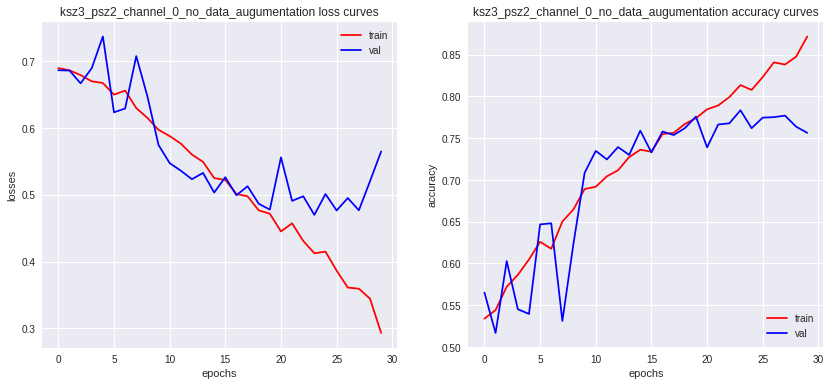

In [15]:
run_models(model_tag="ksz3_psz2_channel_0_no_data_augumentation", channel=channel_0, data_augumentation=False)

Model: ksz3_psz2_channel_1_no_data_augumentation
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)          

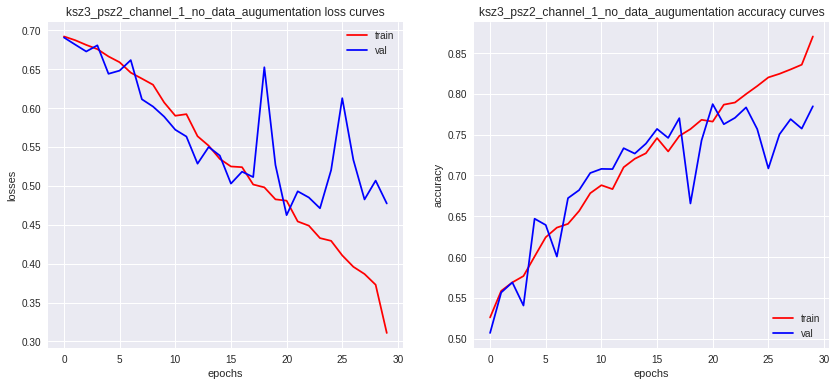

In [16]:
run_models(model_tag="ksz3_psz2_channel_1_no_data_augumentation", channel=channel_1, data_augumentation=False)

Model: ksz3_psz2_channel_2_no_data_augumentation
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)         

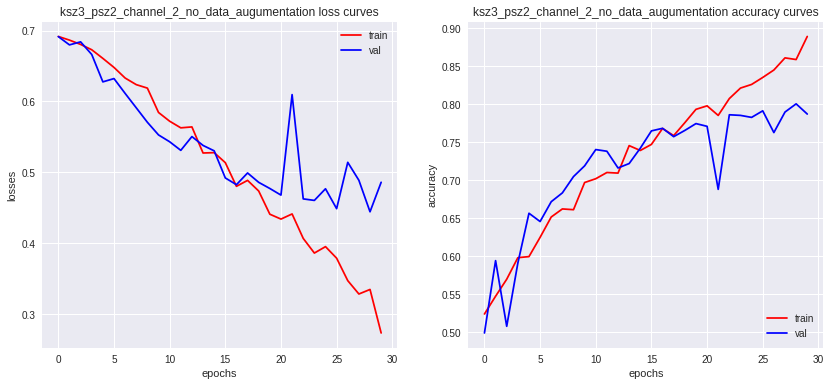

In [17]:
run_models(model_tag="ksz3_psz2_channel_2_no_data_augumentation", channel=channel_2, data_augumentation=False)

Model: ksz3_psz2_channel_3_no_data_augumentation
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 72, 72, 128)       36992     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 34, 34, 256)       295168    
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 17, 17, 256)       0         
_________________________________________________________________
conv2d_16 (Conv2D)         

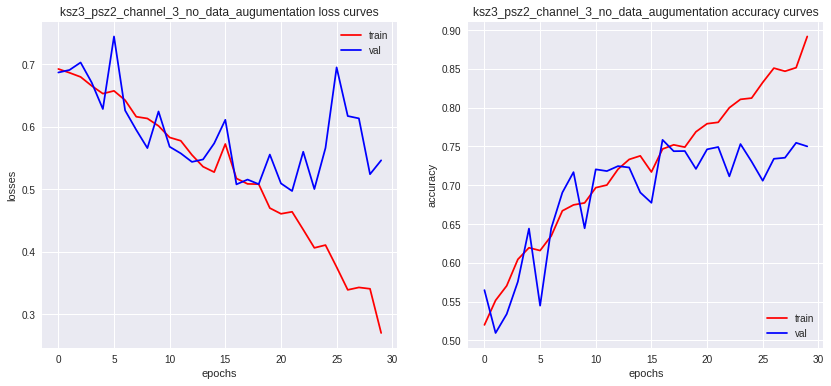

In [18]:
run_models(model_tag="ksz3_psz2_channel_3_no_data_augumentation", channel=channel_3, data_augumentation=False)

**Test each channel configuration with data augumentation**

Model: ksz3_psz2_channel_0_data_augumentation
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (

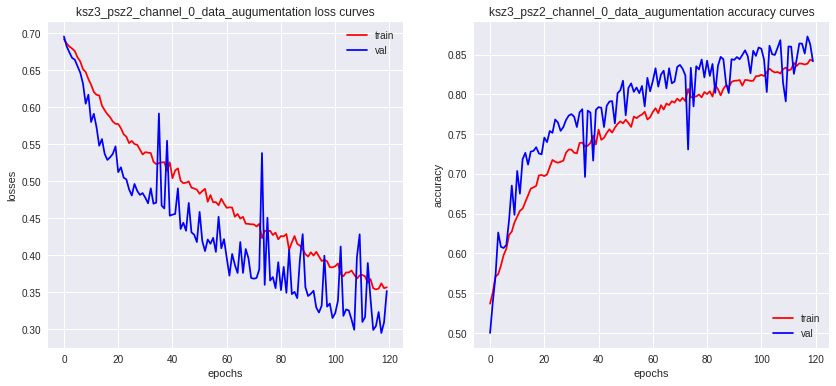

In [19]:
run_models(model_tag="ksz3_psz2_channel_0_data_augumentation", channel=channel_0, data_augumentation=True)

Model: ksz3_psz2_channel_1_data_augumentation
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (

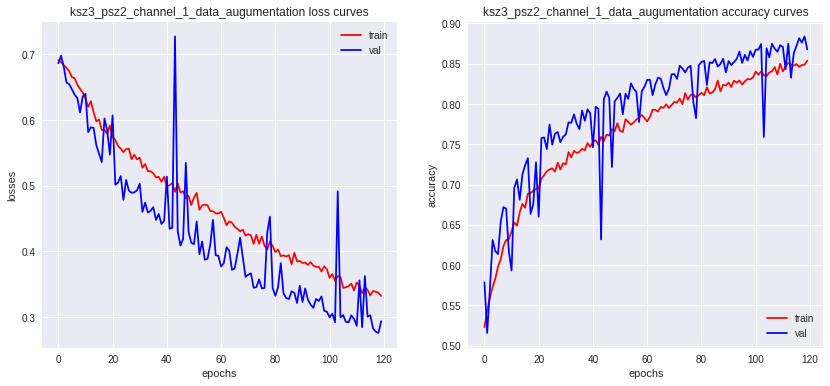

In [20]:
run_models(model_tag="ksz3_psz2_channel_1_data_augumentation", channel=channel_1, data_augumentation=True)

Instructions for updating:
Colocations handled automatically by placer.
Model: ksz3_psz2_channel_2_data_augumentation
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
________________________

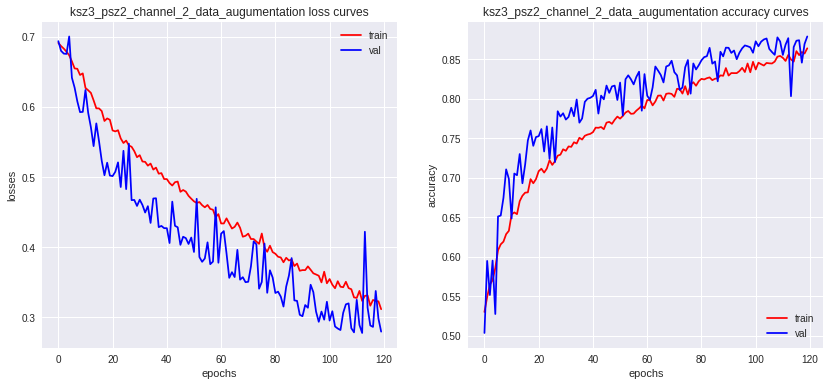

In [15]:
run_models(model_tag="ksz3_psz2_channel_2_data_augumentation", channel=channel_2, data_augumentation=True)

Instructions for updating:
Colocations handled automatically by placer.
Model: ksz3_psz2_channel_3_data_augumentation
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 128)       36992     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 256)       295168    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 256)       0         
________________________

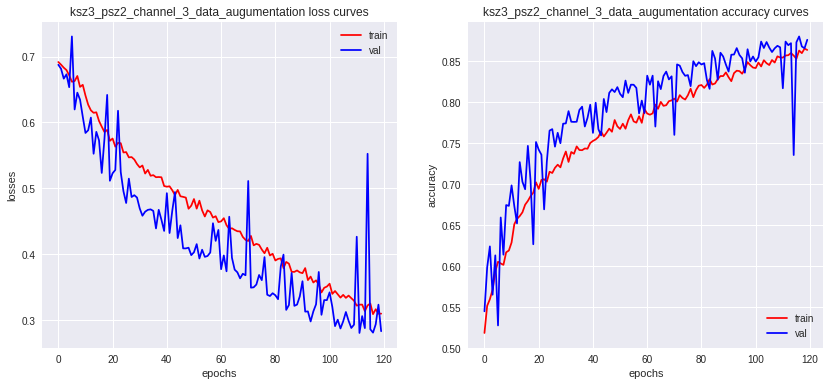

In [15]:
run_models(model_tag="ksz3_psz2_channel_3_data_augumentation", channel=channel_3, data_augumentation=True)

### Verify if best model is saved correctly

In [0]:
# best model tag
print("best_model_tag:", best_model_tag)
# best model reference
print("best_model:", best_model_ref)
# val acc of this best model
print("best_val_acc:", best_val_acc)

## Predict test data

In [0]:
from keras.preprocessing import image
import numpy as np
   
print(best_train_generator.class_indices)

# directory of test data
# the file names should be like: 1.jpg, 2.jpg, ... , 4999.jpg
original_test_dataset_dir = "testset/set"

def load_image(img_path, show=False):
    img = image.load_img(img_path, target_size=(150, 150))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0) 
    img_tensor /= 255.
    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()
    return img_tensor

def getint(name):
    basename = name.partition('.')
    alpha, num = basename.split('_')
    return int(num)

def get_predicts():
    files = os.listdir(original_test_dataset_dir)
    files = sorted(files,key=lambda x: int(os.path.splitext(x)[0]))
    predicts = []
    for file in files:
        if file.endswith(".jpg"):
            # load a single image
            new_image = load_image(os.path.join(original_test_dataset_dir, file))
            # check prediction
            pred = best_model_ref.predict(new_image)
            pred_class = best_model_ref.predict_classes(new_image)
            proba = best_model_ref.predict_proba(new_image)
            if pred_class[0] == 0:
                print("{0} : Cat".format(file))
                # This probability may be used for checking 
                # what probability this image is recognized as cat or dog
                #print("proba : {}".format(proba))
                predicts.append('Cat')
            else:
                print("{0} : Dog".format(file))
                #print("proba : {}".format(proba))
                predicts.append('Dog')
                
    return predicts

## Write csv for Kaggle submission

In [0]:
#write prediction into csv file for submitting result

import datetime
import csv

def write_predicts_to_csv(predicts, file_path):
    with open(file_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter = ',')
        writer.writerow(("id", "label"))
        for i, label in enumerate(predicts):
            writer.writerow((i+1, predicts[i]))
    print("saved csv {0}".format(file_path))
    
file_path = best_model_tag
file_path += str(datetime.datetime.now())
file_path += '.csv'

write_predicts_to_csv(predicts, file_path)